In [1]:
!git clone https://github.com/guillermogotre/cusp-pytorch/
%cd cusp-pytorch

fatal: destination path 'cusp-pytorch' already exists and is not an empty directory.
/content/cusp-pytorch


In [2]:
import os
import time
import pickle

import torch
import torch.nn.functional as F

import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

# Custom modules
from training.networks import VGG, module_no_grad
import legacy
from torch_utils import misc
import dnnlib

# GDrive authentication and Download
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Google Drive
First we configure GDrive for model download.

Authenticated downloads prevent Google from blocking the file.

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Running configuration

```KEY``` defines the running model. The options are:
- ```FFHQ_RR_KEY``` for FFHQ-RR dataset (20 to 69)
- ```FFHQ_LS_KEY``` for FFHQ-LS dataset (binarized 0 to 100)

In [4]:
FFHQ_LS_KEY = "lats"  # Model trained on LATS dataset
FFHQ_RR_KEY = "hrfae" # Model trained on HRFAE dataset

# Choose one from above
# KEY = FFHQ_RR_KEY # [HRFAE_KEY or LATS_KEY]
KEY = FFHQ_LS_KEY # [HRFAE_KEY or LATS_KEY]

# Config and GDrive ID
vgg_path_gdrive_id = '1a0jghZx44uC_kIIvD-UEcNp4Xz8Bpso1'
configs = {
    FFHQ_LS_KEY: dict(
        gdrive_id="1sWSH3tHgm9DkHrc19hoEMrR-KQgnaFuw",
        side=256,
        classes=(1,8)),
    FFHQ_RR_KEY: dict(
        gdrive_id="17BOTEa6z3r6JFVs1KDutDxWEkTWbzaeD",
        side=224,
        classes=(20,65))
}

# CUDA device
device = torch.device('cuda',0)
# Images path
sample_images_path= "sample_images" # Samples are taken from FFHQ
# Model GDrive ID
model_id = configs[KEY]['gdrive_id']
# Side of input images
img_side = configs[KEY]['side']
# Labels range for examples generation
data_labels_range = configs[KEY]['classes']

In [5]:
# SAMPLE IMAGES #
# Read image filenames
# filenames_batch = [
#       os.path.join(sample_images_path,f)
#       for  f in next(iter(os.walk(sample_images_path)))[2]
#       if f[-4:] == '.png'
#     ]

# CUSTOM IMAGES #
from google.colab import drive
drive.mount('/content/drive',
            #force_remount=True,
           )

sample_images_path = "/content/drive/MyDrive/masters/2024_25-02/biometrics/cusp_input"

filenames_batch = [
    os.path.join(sample_images_path, f)
    for f in os.listdir(sample_images_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Add error handling for empty directories
if not filenames_batch:
    raise FileNotFoundError(f"No images found in {filenames_batch}. "
                            "Ensure: 1) Drive mounted correctly, "
                            "2) Images are PNG/JPG, 3) Path is correct")

print(filenames_batch)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/masters/2024_25-02/biometrics/cusp_input/kutay_01_22.jpg']


The pretrained serialized models are downloaded from Google Drive

In [7]:
drive

<module 'google.colab.drive' from '/usr/local/lib/python3.11/dist-packages/google/colab/drive.py'>

In [6]:
def download_gdrive_id(gid, file_path):
  begin = time.time()
  gfile = drive.CreateFile(dict(id=gid))
  gfile.GetContentFile(file_path)

  print(f"File {gfile['title']} ({gid}) downloaded to {file_path} in {time.time()-begin} seconds")
# Destination paths
weights_path = "pretrained.pkl"
vgg_path = "dex_imdb_wiki.caffemodel.pt"
# Download models
download_gdrive_id(vgg_path_gdrive_id,vgg_path)
download_gdrive_id(model_id,weights_path)

AttributeError: module 'google.colab.drive' has no attribute 'CreateFile'

The network snapshop downloaded from ```model_id``` has 4 (key,values) tuples:
- ```G```: Generator weights on last training iteration
- ```G_ema```: Exponential moving average for the generator weights. It yields a more stable model for generation. (**THIS IS THE ONE WE'LL USE**)
- ```D```: Discriminator weights
- ```config```: Some training configuration parameters

Then we have to load de DEX age classifier, disable gradients, and add it to the Generator.

In [ ]:
def load_model(model_path,vgg_path,device):
    with open(model_path,'rb') as f:
        contents = legacy.load_network_pkl(f) # Pickles weights and source code

    # Get exponential movign average model
    G_ema = contents['G_ema']

    # Load DEX VGG classifier
    vgg = VGG()
    vgg_state_dict = torch.load(vgg_path)
    vgg_state_dict = {k.replace('-', '_'): v for k, v in vgg_state_dict.items()}
    vgg.load_state_dict(vgg_state_dict)
    module_no_grad(vgg) #!important

    # Set classifier
    G_ema.skip_grad_blur.model.classifier = vgg
    # No grad
    G_ema = G_ema.to(device).eval().requires_grad_(False)
    # No grad on VGG

    return G_ema

G_ema = load_model(
    weights_path,
    vgg_path,
    device)

The image generation process is comprised of several steps:
- Input images are run through the Content Encoder and the Style Encoder.
- Target age labels are One-Hot encoded and run through the Age Mapping network.
- Global blur and CUSP masked blur are applied on the skip connections.
- The decoder is fed with the Content Encoder 2D tensors and the Age/Style 1D embedding.

In [ ]:
def run_model(G, img, label, global_blur_val=None, mask_blur_val=None, return_msk = False):
    # Tranform label to One Hot Encoding
    cls = torch.nn.functional.one_hot(
        torch.tensor(label),
        num_classes=G.attr_map.fc0.init_args[0]
    ).to(img.device)

    # Content encoder
    _,c_out_skip = G.content_enc(img)

    # Style encodder
    s_out = G.style_enc(img)[0].mean((2, 3))

    truncation_psi=1
    truncation_cutoff=None
    s_out = G.style_map(s_out, None, truncation_psi, truncation_cutoff)

    # age mapping
    a_out = G.attr_map(cls.to(s_out.device), None, truncation_psi, truncation_cutoff)

    # Style mapping and Age mapping are interleaved for the corresponding
    # weight demodulation modules
    w = G.__interleave_attr_style__(a_out, s_out)

    # Global blur
    for i,(f,_) in enumerate(zip(G.skip_transf, c_out_skip)):
        if f is not None:
            c_out_skip[i] = G._batch_blur(c_out_skip[i], blur_val = global_blur_val)

    # Masked blur
    cam = G.skip_grad_blur(img.float())
    msk = cam
    for i, (f, c) in enumerate(zip(G.skip_transf, c_out_skip)):
        if f is not None:
            im_size = c.size(-1)
            blur_c = G._batch_blur(c, blur_val= mask_blur_val)
            if msk.size(2) != im_size:
                msk = F.interpolate(msk,size=(im_size,im_size), mode='area')
            merged_c = c * msk + blur_c * (1 - msk)
            c_out_skip[i] = merged_c


    # Decoder
    img_out = G.image_dec(c_out_skip, w)

    if return_msk:
        to_return = (img_out,msk,cam) if G.learn_mask is not None else (img_out,None,None)
    else:
        to_return = img_out

    # assert(all(x.grad is None for x in G.parameters()))
    # assert(all(x.grad is None for x in G.skip_grad_blur.model.get_classifier().parameters()))
    # G.zero_grad()

    return to_return

Data is prepared to be fed to the Generator. The number of steps for this examples is defined dynamically by ```steps```.

In [ ]:
# Image side
side = configs[KEY]['side']
# Read images
imgs = [np.array(PIL.Image.open(f).resize((side,side)),dtype=np.float32).transpose((2,0,1)) for f in filenames_batch]
# Transform to tensors
im_in_tensor = (torch.tensor(np.array(imgs))/256*2-1).cuda() # Values {-1,1}

# Aging steps
steps = 4 # N steps
# Repeat images N times
n_images = im_in_tensor.shape[0]
im_in_tensor_exp = im_in_tensor[:,None].expand([n_images,steps,*im_in_tensor.shape[1:]]).reshape([-1,*im_in_tensor.shape[1:]])
# Define target ages
labels_exp = torch.tensor(np.repeat(np.linspace(*data_labels_range,steps,dtype=int)[:,None],n_images,1).T.reshape(-1))

In a batch-sized fashion we run our data through the model.

The two parameters for the CUSP module range from 0 to 1 and are the following:
- ```global_blur_val```: Global blur applied on the skip connection.
- ```mask_blur_val```: Guided-backpropagation-based masking on age specific areas.

The Custom Preservation (CP) config corresponds to ```global_blur_val=0.2``` and ```mask_blur_val=0.8```

_The output of this window is not shown to hide the printed warnings. The code needs to be run in its corresponding Pytorch Docker environment to run efficiently with Nvidia custom CUDA modules._

In [ ]:
%%capture
batch_size = 12
# Run model
im_out_tensor_exp = torch.concat([run_model(
    G_ema,
    mini_im,
    mini_label,
    global_blur_val=0.2, # CUSP global blur
    mask_blur_val=0.8)   # CUSP masked blur
    for mini_im, mini_label
    in zip(
        im_in_tensor_exp.split(batch_size),
        labels_exp.split(batch_size)
    )])
# Transform to [batch_size, N_ages, W, H , C]
im_out_tensor = im_out_tensor_exp.reshape([-1,steps,*im_out_tensor_exp.shape[1:]])

The result is laid out in 5 columns, from left to right: Input Image and Steps 1 to 4 from the corresponing age label range defined in ```configs[KEY]['classes']```.

_Labels are meaningless on FFHQ-LS, you should refer to LATS work for the corresponding bins' age brackets_

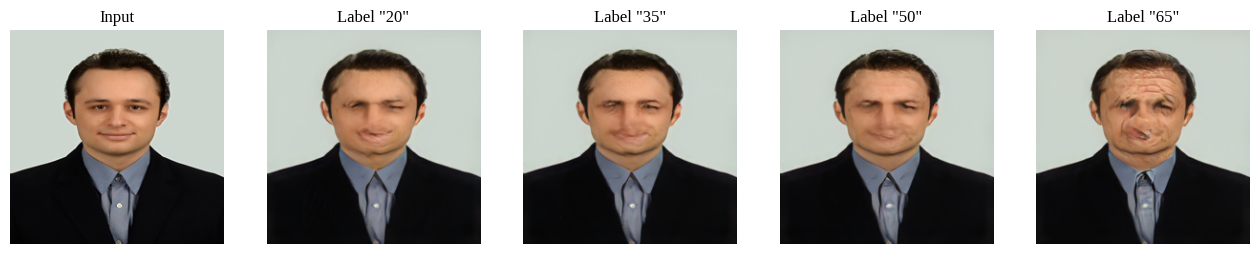

In [ ]:
# Transform tensor to uint8 image
def to_uint8(im_tensor):
    im_tensor = (im_tensor.detach().cpu().numpy().transpose((1,2,0))+1)*(256/2)
    im_tensor = np.clip(im_tensor,0,255).astype(np.uint8)
    return im_tensor
# For every input image
for fname, im_in, im_out, age_labels in zip(
        filenames_batch,im_in_tensor,im_out_tensor,
        labels_exp.numpy().reshape(-1,steps)
        ):
    # Create figure
    fig,axs = plt.subplots(1,steps+1,figsize=(steps*4,4),dpi=100)
    age_labels = ['Input'] + [f'Label "{i}"' for i in age_labels]
    # For every [input,step...]
    for ax,im,l in zip(axs,[im_in,*im_out],age_labels):
        ax.axis('off')
        ax.imshow(to_uint8(im))
        ax.set_title(l,fontname='Liberation Serif')